#### The Randomisation Test

The randomisation test, also called a permutation test, is a neat idea in statistics. The intuition is quite simple - under the null hypothesis, the label assigned to each sample is interchangeable because each sample came from a single distribution. A randomisation test shuffles the labels assigned to each point and calculates the difference between both groups. If we do this repeatedly, we can build up a distribution of the differences between both groups. Finally we can compare the point difference obtained with the permutation distribution obtained - if a difference equal to or more extreme than the point difference is rare, we conclude that the probability that our original assumption, that both groups are interchangeable, is false.

In the quick post below, I work through two examples from the book *Statistics for Experimenters*. In the first, I use a randomisation test in place of an independent samples t-test. In the second I use ...

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Comparison of Standard and Modified Fertilizer Mixtures for Tomato Plants

The following example was given in *Statistics for Experimenters* of data collected by a gardener who wanted to know which fertilizer mixture would result in the largest yield. The data is shown below

In [2]:
df = pd.DataFrame({'label': ['A', 'A', 'B', 'B', 'A', 'B', 'B', 'B', 'A', 'A', 'B'], 
                   'yield': [29.9, 11.4, 26.6, 23.7, 25.3, 28.5, 14.2, 17.9, 16.5, 21.1, 24.3]})
df.head()

,label,yield
0,A,29.9
1,A,11.4
2,B,26.6
3,B,23.7
4,A,25.3


We can use this data to compare the results obtained from the randomisation test and t-test.

#### Plot the Randomisation Distribution

In [3]:
point_estimate = df[df.label == 'B']['yield'].mean() - df[df.label == 'A']['yield'].mean()

A true permutation test entails computing all possible permutations of your dataset. Here we approximate this by repeatedly resampling our dataset; for a large number of resamples this should approximate a true permutation test.

In [4]:
num_simulations = 5000
differences = []
for _ in range(num_simulations):
    shuffled = np.random.permutation(df['label'])
    diff = df[shuffled == 'B']['yield'].mean() - df[shuffled == 'A']['yield'].mean()
    differences.append(diff)

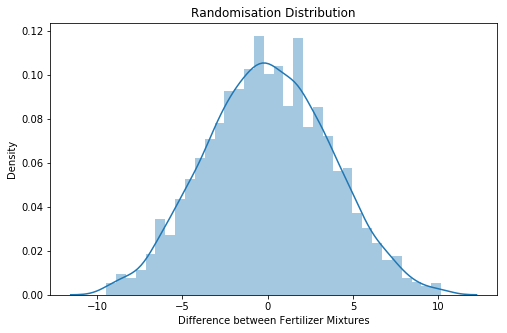

In [5]:
plt.figure(figsize=(8,5))
sns.distplot(differences)
plt.title('Randomisation Distribution')
plt.xlabel('Difference between Fertilizer Mixtures')
plt.ylabel('Density');

Plot the analytically derived t-distribution

In [6]:
def calculate_sum_squares(data, mean):
    return (np.square(np.subtract(data, mean))).sum()

def calculate_se(data1, data2):
    "Calculate the Pooled standard error of yb - ya"
    mean1, mean2 = data1.mean(), data2.mean()
    var1, var2 = calculate_sum_squares(data1, mean1), calculate_sum_squares(data2, mean2)
    pooled_var = (var1 + var2) / (len(data1) + len(data2) - 2)
    variance_of_diff = pooled_var * ((1/len(data1)) + (1/len(data2)))
    return np.sqrt(variance_of_diff)

In [7]:
# np.random.shuffle changes the dataframe in place so re-create below.
df = pd.DataFrame({'label': ['A', 'A', 'B', 'B', 'A', 'B', 'B', 'B', 'A', 'A', 'B'], 
                   'yield': [29.9, 11.4, 26.6, 23.7, 25.3, 28.5, 14.2, 17.9, 16.5, 21.1, 24.3]})

data1, data2 = df[df.label == 'B']['yield'], df[df.label == 'A']['yield']
mean = 0 # null hypothesis
se = calculate_se(data1, data2)

x = np.linspace(mean - 3*se, mean + 3*se, 1000)
degrees_freedom = len(data1) + len(data2) - 2
t_dist = t(degrees_freedom, mean, se)

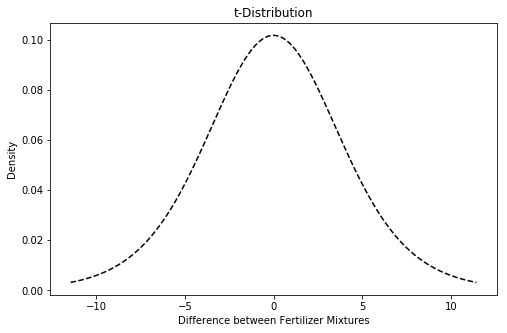

In [8]:
plt.figure(figsize=(8,5))
plt.plot(x, t_dist.pdf(x), linestyle='--', color='black')
plt.title('t-Distribution')
plt.xlabel('Difference between Fertilizer Mixtures')
plt.ylabel('Density');

#### Let's plot both on the same axis

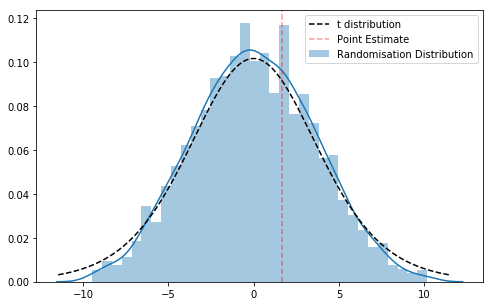

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.distplot(differences, hist=True, label='Randomisation Distribution', ax=ax);
plt.plot(x, t_dist.pdf(x), linestyle='--', label='t distribution', color='black')
ax.axvline(point_estimate, label='Point Estimate', linestyle='--', color='r', alpha=.4)
ax.legend(loc='best')

Both distributions follow each other closely. Computing the p-value associated with the observed difference is simple for the permutation test - we simply calculate how many observed samples had a difference equal to or greater than the observed difference (for a one-tailed test). In this case, the value is: 

In [10]:
p = len([d for d in differences if d >= point_estimate]) / num_simulations
print (p)

0.3356


The results from the t-distribution match up very closely.

In [11]:
from statsmodels.stats.weightstats import ttest_ind
t, p, dof = ttest_ind(df[df.label =='B']['yield'], df[df.label =='A']['yield'],
                      alternative = 'larger', usevar='pooled')
print (p)

0.3338726599549591


#### Boys Shoes' Design

Another example given in *Statistics for Experimenters* describes a paired design to determine the best material to use for shoe soles. Each boy wears material A on one foot and material B on the other; by making comparisons within matched pairs we remove the boy-to-boy variation, increasing the precision. 

This is another problem where we can use the randomisation distribution in place of the repeated samples t-test.

The data is shown below showing the amount of wear shoe soles made of materials A and B.

In [55]:
df = pd.DataFrame({'label_a': [13.2, 8.2, 10.9, 14.3, 10.7, 6.6, 9.5, 10.8, 8.8, 13.3],
                   'label_b': [14, 8.8, 11.2, 14.2, 11.8, 6.4, 9.8, 11.3, 9.3, 13.6]})                
point_estimate = np.mean(df.label_b - df.label_a)
df.head()

,label_a,label_b
0,13.2,14.0
1,8.2,8.8
2,10.9,11.2
3,14.3,14.2
4,10.7,11.8


In this case we shuffle the values of label A and label B between samples (rows). This is because under the null hypothesis there is no difference in the materials and the value for label B could just have easily been recorded for label A. Repeatedly doing this constructs the sampling distribution.

In [57]:
# randomisation distribution
num_simulations = 5000
differences = []
for _ in range(num_simulations):
    df_shuffled = df.apply(np.random.permutation,axis=1, result_type='expand')
    df_shuffled.columns = ['label_a', 'label_b']
    mean_diff = np.mean(df_shuffled['label_b'] - df_shuffled['label_a'])
    differences.append(mean_diff)

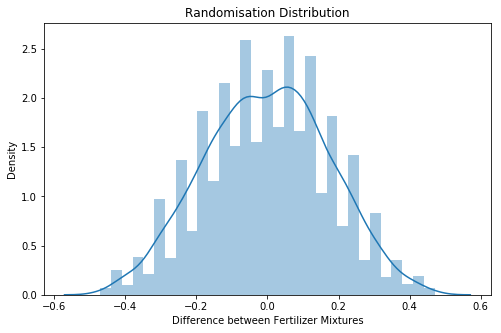

In [58]:
plt.figure(figsize=(8,5))
sns.distplot(differences)
plt.title('Randomisation Distribution')
plt.xlabel('Difference between Fertilizer Mixtures')
plt.ylabel('Density');

#### Plot the analytical solution

In [64]:
# np.random.permutation changes the dataframe in place so re-create below.
df = pd.DataFrame({'label_a': [13.2, 8.2, 10.9, 14.3, 10.7, 6.6, 9.5, 10.8, 8.8, 13.3],
                   'label_b': [14, 8.8, 11.2, 14.2, 11.8, 6.4, 9.8, 11.3, 9.3, 13.6]})      

mean = 0 # null hypothesis
deg_freedom = len(df) - 1

def calculate_se (df):
    "Calculate Standard Error for Repeated t-test"
    d_average = np.mean(df.label_b - df.label_a)
    diff = (df.label_b - df.label_a) - d_average
    squared_diff = np.square(diff)
    sum_squared_diff = np.sum(squared_diff)
    var = sum_squared_diff / deg_freedom
    se = np.sqrt(var/len(df))
    return se

In [65]:
se = calculate_se(df)
x = np.linspace(mean - 3*se, mean + 3*se, 1000)
t_dist = t(deg_freedom, mean, se)

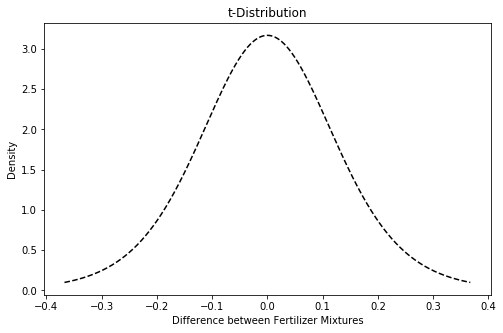

In [66]:
plt.figure(figsize=(8,5))
plt.plot(x, t_dist.pdf(x), linestyle='--', color='black')
plt.title('t-Distribution')
plt.xlabel('Difference between Fertilizer Mixtures')
plt.ylabel('Density');

#### Let's plot both on the same axis

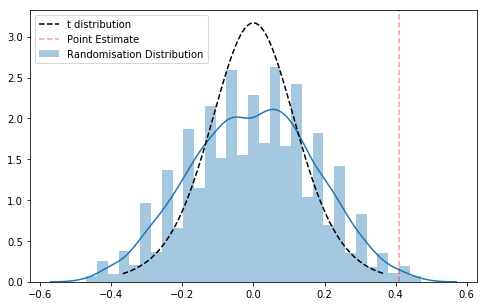

In [67]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.distplot(differences, hist=True, label='Randomisation Distribution', ax=ax);
plt.plot(x, t_dist.pdf(x), linestyle='--', label='t distribution', color='black')
ax.axvline(point_estimate, label='Point Estimate', linestyle='--', color='r', alpha=.4)
ax.legend(loc='best')

Again we can compute a p-value. In this case we will perform a two-tailed test.

In [76]:
p = len([d for d in differences if abs(d) >= point_estimate]) / num_simulations
print (p)

0.0176


And we can compare this to the analytical t-test.

In [77]:
from scipy.stats import ttest_rel
_, p = ttest_rel(df['label_b'], df['label_a'])
print (p)

0.00853878071759894


#### Conclusion

The randomisation distribution offers an intuitive computational alternative to more analytical statistical methods. I encourage you all to check out the linked talks below – both fantastic talks!

#### Acknowledgements

I found the following resources useful:
- [John Rauser keynote: "Statistics Without the Agonizing Pain"](https://youtu.be/5Dnw46eC-0o)
- [Jake Vanderplas - Statistics for Hackers](https://youtu.be/Iq9DzN6mvYA)